In [21]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV,GridSearch 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
import matplotlib.pyplot as plt

def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

ImportError: cannot import name 'GridSearch' from 'sklearn.model_selection' (/Users/moi6/opt/miniconda3/envs/basico/lib/python3.10/site-packages/sklearn/model_selection/__init__.py)

In [2]:
data = pd.read_csv("dados_classificacao/dados_hospital.csv", sep=',')

target = 'no_show'

le = LabelEncoder()
for cl in data.columns:
    if data[cl].dtypes==np.object0:
        data[cl] = le.fit_transform(data[cl])
data.dtypes.value_counts()

X, y = data.drop([target,'cancer'], axis=1), data[target]

X_traina, X_testa, y_traina, y_testa = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)


Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 2.5 * IQR
limite_superior = Q3 + 2.5 * IQR
data_sem_outliers = data[(data >= limite_inferior) & (data <= limite_superior)]

data_sem_outliers.dropna(inplace=True)

X_so = data_sem_outliers.drop([target,'cancer'], axis=1)
y_so = data_sem_outliers[target]
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_so,y_so,test_size=0.2, stratify=y_so, random_state=0)

dt = [[X_traina,y_traina,X_testa,y_testa],[X_trainb,y_trainb,X_testb,y_testb]]

[0.54103849 0.54771022 0.48711413] [0.44936184083100505, 0.32379248658318427]
[[  75   36]
 [1098  468]]


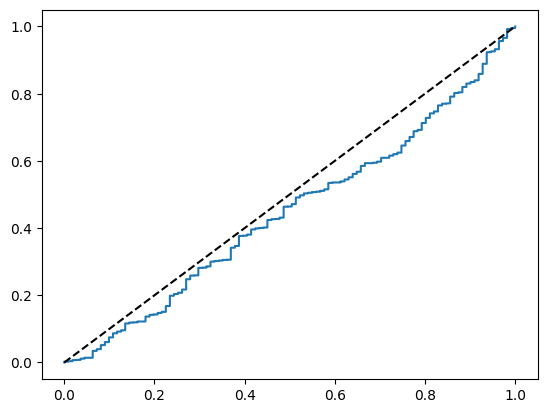

In [15]:
X_train,y_train,X_test,y_test = dt[0]

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

poly = PolynomialFeatures(degree = 4)
pipe = Pipeline([('poli',poly),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1e-15,max_iter=1000000))]) 

cvr = cross_validate(pipe, X_train, y_train, cv = 3, scoring=my_scorer, return_estimator=True)
scores = cvr['test_score']
estimators = cvr['estimator']
best_model = estimators[np.argmax(cvr['test_score'])]
y_pred = best_model.predict_proba(X_test)[:,0]
print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Curva ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

0.63837847715685 [0.4833471102910701, 0.4275491949910555]
{'modelo__C': 5.09e-19, 'poli__degree': 1}
[[ 62  49]
 [911 655]]


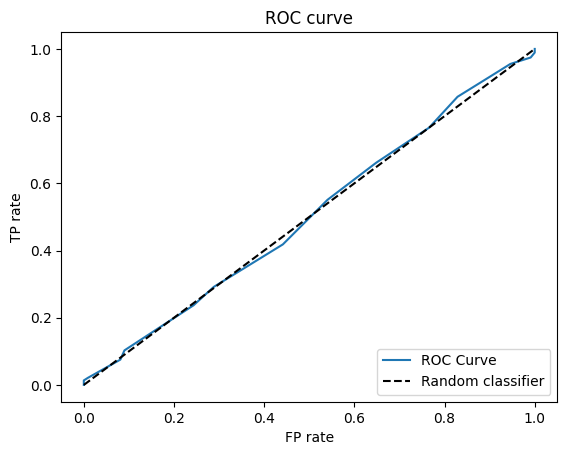

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)


 
param_grid = {
    "poli__degree": [1,2,4],
    "modelo__C":np.linspace(1.0e-20,5.0e-18,11),
}

pipe = Pipeline([('poli',PolynomialFeatures()),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',max_iter=1000000))])
# pipe = Pipeline([('poli',PolynomialFeatures()),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',solver='lbfgs',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer,cv = 3, n_jobs=-1)
search.fit(X_resampled, y_resampled)
bests = search.best_estimator_
y_pred = bests.predict_proba(X_test)[:,0]
print(search.best_score_,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5)])
print(search.best_params_)
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
minha_metrica(y_resampled,bests.predict_proba(X_resampled)[:,0])

0.3536264806711516

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection


balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)


 
param_grid = {
    "modelo__C":np.linspace(10,100,5),
    "modelo_gamma" : ['scale','auto',0.001, 0.1, 1, 10]
}

pipe = Pipeline([('poli',PolynomialFeatures(4)),('escala',StandardScaler()),('modelo', NuSVC(kernel='rbf',gamma = 'scale'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_resampled, y_resampled)
bests = search.best_estimator_
scores = search.best_score_

# search = cross_validate(pipe, X_resampled, y_resampled, cv = 3, scoring = my_scorer, return_estimator = True)
# scores = search['test_score']
# estimators = search['estimator']
# bests = estimators[np.argmax(cvr['test_score'])]

y_pred = bests.predict(X_test)
print(search.best_params_)

print(scores,[minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred)])
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

[0.5303367351263627, 0.3382219257643996]
0.5040594359750199 0.5116279069767442
[[ 55  56]
 [763 803]]


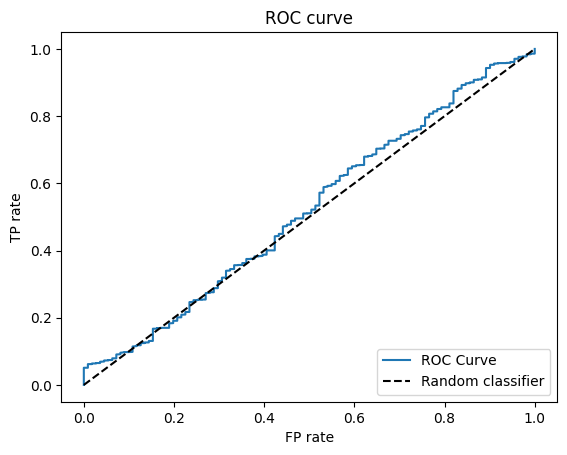

In [77]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

dg = 4

pipe = Pipeline([('poli',PolynomialFeatures(degree=dg)),('escala',StandardScaler()),('modelo', LogisticRegression(penalty='l2',C = 3.25e-18,max_iter=1000000))])

search = pipe.fit(X_resampled,y_resampled)
y_pred = search.predict_proba(X_test)[:,0]
print([minha_metrica(y_train,search.predict_proba(X_train)[:,0]),minha_metrica(y_resampled,search.predict_proba(X_resampled)[:,0])])
print(minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5))
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection

balancear = SMOTE()

X_train,y_train,X_test,y_test = dt[0]
X_resampled, y_resampled = balancear.fit_resample(X_train, y_train)

my_scorer = make_scorer(minha_metrica,greater_is_better=True)

dg = 2

pipe = Pipeline([('poli',PolynomialFeatures(degree=dg)),('escala',StandardScaler()),('modelo', NuSVC(kernel='rbf',C = 1, gamma = 'scale'))])

search = pipe.fit(X_resampled,y_resampled)
y_pred = search.predict_proba(X_test)[:,0]
print(minha_metrica(y_train,search.predict(X_train)[:,0]),minha_metrica(y_resampled,search.predict(X_resampled)[:,0]))
print(minha_metrica(y_test,y_pred),accuracy_score(y_test,y_pred>=0.5))
print(confusion_matrix(y_pred=y_pred>=0.5,y_true=y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

AttributeError: predict_proba is not available when  probability=False